#### LangGraph Tutorial — From Simple Chat to Tool-Calling Agent with Memory

In [26]:

# This notebook-style script walks through building progressively smarter
# LangGraph workflows:
#   1. Simple chatbot (no tools)
#   2. Agent with a custom tool (weather search)
#   3. Agent with memory (multi-turn conversation)


In [3]:
from dotenv import load_dotenv
load_dotenv()
import os

In [4]:
# operator: Used for message accumulation in state
import operator

# typing: For type hints (helps with code clarity)
from typing import Annotated, Sequence, TypedDict

# pydantic: For structured data validation
from pydantic import BaseModel, Field

# LangChain components for prompts and parsing
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.output_parsers import PydanticOutputParser

# LangChain message types (important for conversation tracking)
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

# LangChain runnable for chaining operations
from langchain_core.runnables import RunnablePassthrough

# LangGraph for building the agent workflow
from langgraph.graph import StateGraph, END

In [6]:
from langchain_groq import ChatGroq

# Initialize the language model
# This is the "brain" that will answer questions

model = ChatGroq(
    model="openai/gpt-oss-120b",  # Use actual Groq model
    #api_key="your-groq-api-key-here",  # Get from https://console.groq.com
    temperature=0.7
)

llm = model  # Alias for clarity in the agent context

In [7]:
print(type(llm))

<class 'langchain_groq.chat_models.ChatGroq'>


In [8]:
# Test the model (optional)
response = model.invoke("Hello")
print(response.content)

Hello! How can I assist you today?


In [9]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode

In [10]:
print(type(llm))


<class 'langchain_groq.chat_models.ChatGroq'>


### PART 1 — Simple Chatbot (no tools)

In [ ]:

def call_model(state: MessagesState) -> dict:
    """
    Core node function: takes the current conversation state,
    calls the LLM, and returns the new AI message to append.

    'state["messages"]' is the full conversation history so far.
    LangGraph automatically merges the returned message into the state.
    """
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


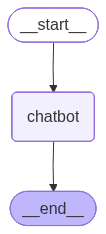

Hi! I'm doing great, thanks for asking. How can I help you today?


In [13]:
# Build the graph ─────────────────────────────────────────────────────────────
# StateGraph(MessagesState) gives us a built-in state schema that stores a
# running list of messages and handles merging automatically.

from IPython.display import Image, display
simple_graph = StateGraph(MessagesState)

# Add a single node called "chatbot" that runs our call_model function
simple_graph.add_node("chatbot", call_model)

# Wire up the edges: START → chatbot → END  (linear, no branching)
simple_graph.add_edge(START, "chatbot")
simple_graph.add_edge("chatbot", END)

# Compile turns the graph definition into a runnable app
simple_app = simple_graph.compile()

# Visualise the graph (works in Jupyter / IPython)
display(Image(simple_app.get_graph().draw_mermaid_png()))

# Run it
response = simple_app.invoke({"messages": ["hi, how are you?"]})
print(response["messages"][-1].content)


### PART 2 — Agent with Tool Calling (Weather Search)

In [ ]:
# ── 2a. Define a Custom Tool ──────────────────────────────────────────────────
# The @tool decorator converts a plain Python function into a LangChain tool.
# The docstring becomes the tool's description — the LLM reads it to decide
# WHEN to call the tool, so write it clearly!

@tool
def search(query: str) -> str:
    """Search for current weather conditions in a city."""
    if "delhi" in query.lower():
        return "The temperature is 45°C and it's sunny."
    return "The temperature is 25°C and it's cloudy."


# Quick test to confirm the tool works independently
print(search.invoke("weather in Delhi"))    # → 45°C sunny
print(search.invoke("weather in Kashmir")) # → 25°C cloudy


The temperature is 45°C and it's sunny.
The temperature is 25°C and it's cloudy.


In [15]:
# ── 2b. Bind Tools to the LLM ────────────────────────────────────────────────
# bind_tools() tells the LLM about the available tools.
# When the LLM decides to use a tool, it returns a special AIMessage
# with `.tool_calls` populated instead of filling `.content`.

tools = [search]
llm_with_tools = llm.bind_tools(tools)

In [16]:
# ── 2c. Update call_model to use the tool-aware LLM ──────────────────────────
def call_model_with_tools(state: MessagesState) -> dict:
    """Node: invokes the LLM that knows about our tools."""
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

In [17]:
# ── 2d. Router — should we stop or call a tool? ───────────────────────────────
def router(state: MessagesState) -> str:
    """
    Conditional edge function.
    Inspects the last message:
      • If the LLM requested a tool call  → route to "tools" node
      • Otherwise (normal reply)           → route to END
    """
    last_message = state["messages"][-1]
    if last_message.tool_calls:   # LLM wants to call a tool
        return "tools"
    return END                    # LLM has a final answer

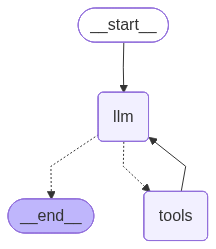

In [18]:
# ── 2e. Build the Tool-Calling Graph ──────────────────────────────────────────
# ToolNode is a pre-built LangGraph node that:
#   1. Reads the tool_calls from the last AIMessage
#   2. Executes the matching tool(s)
#   3. Returns ToolMessage(s) with the results

tool_node = ToolNode(tools)

agent_graph = StateGraph(MessagesState)

agent_graph.add_node("llm", call_model_with_tools)   # LLM reasoning node
agent_graph.add_node("tools", tool_node)              # Tool execution node

agent_graph.add_edge(START, "llm")

# Conditional edge: after the LLM responds, router decides what happens next
agent_graph.add_conditional_edges(
    "llm",          # source node
    router,         # function that returns the next destination
    {
        "tools": "tools",   # if router returns "tools" → go to tool node
        END: END,           # if router returns END     → finish
    }
)

# After a tool runs, always go back to the LLM so it can process the result
agent_graph.add_edge("tools", "llm")

agent_app = agent_graph.compile()

display(Image(agent_app.get_graph().draw_mermaid_png()))

In [19]:
# ── 2f. Test the Agent ───────────────────────────────────────────────────────
# Stream output so we can see each node's contribution step-by-step
print("\n--- Streaming: weather in New Delhi ---")
for step in agent_app.stream({"messages": ["What is the weather in New Delhi?"]}):
    for node_name, node_output in step.items():
        print(f"\n[{node_name}]")
        print(node_output["messages"][-1])


--- Streaming: weather in New Delhi ---

[llm]
content='' additional_kwargs={'tool_calls': [{'id': 'fc_02a50152-9684-4581-9b0d-f6c8b60b76c1', 'function': {'arguments': '{"query":"current weather New Delhi"}', 'name': 'search'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 129, 'total_tokens': 186, 'completion_time': 0.119564575, 'completion_tokens_details': {'reasoning_tokens': 28}, 'prompt_time': 0.026445142, 'prompt_tokens_details': None, 'queue_time': 0.05214326, 'total_time': 0.146009717}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_626f3fc5e0', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--d0530c3a-0f01-41cd-baab-9686cb8e9b08-0' tool_calls=[{'name': 'search', 'args': {'query': 'current weather New Delhi'}, 'id': 'fc_02a50152-9684-4581-9b0d-f6c8b60b76c1', 'type': 'tool_call'}] usage_metadata={'input_tokens': 129, 'output_tokens': 57, 'total_tokens': 186}

[tools]
content="The temperature is 45°C a

### PART 3 — Persistent Memory (Multi-Turn Conversations)

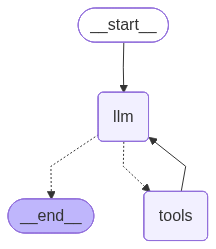

In [21]:
# MemorySaver stores the full message history in memory (per thread_id).
# In production you'd swap this for a database-backed checkpointer.

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

# We reuse the same graph structure — only the compiler call changes
memory_app = agent_graph.compile(checkpointer=memory)

display(Image(memory_app.get_graph().draw_mermaid_png()))

# A config dict identifies the conversation "thread".
# Using the same thread_id across calls gives the bot memory of past turns.
config = {"configurable": {"thread_id": "user-session-1"}}


In [22]:
def chat(user_message: str) -> None:
    """Helper: send a message and pretty-print the final AI reply."""
    print(f"\nUser: {user_message}")
    events = memory_app.stream(
        {"messages": [user_message]},
        config=config,
        stream_mode="values",
    )
    for event in events:
        last = event["messages"][-1]
        # Only print AI messages (skip intermediate tool/human messages)
        if isinstance(last, AIMessage) and last.content:
            print(f"Bot : {last.content}")


In [23]:
# Turn 1 — ask about Delhi weather
chat("What is the weather in New Delhi?")


User: What is the weather in New Delhi?
Bot : The current weather in New Delhi is **45 °C** with **sunny** conditions.


In [24]:
# Turn 2 — follow-up about Indore (bot still has Delhi context in memory)
chat("What about Indore?")


User: What about Indore?
Bot : The current weather in **Indore** is **25 °C** with **cloudy** conditions.


In [25]:
# Turn 3 — completely different topic; bot should handle gracefully
chat("Thanks! What city did I ask about first?")



User: Thanks! What city did I ask about first?
Bot : You first asked about **New Delhi**.
